The sticky air method is a good way to simulate a free surface for Eulerian approaches, provided that its parameters are chosen carefully ($C\ll1$).

2.1.1 Isostatic timescale

$C_{isost}= \frac{3}{16\pi^{3}}(\frac{L}{h_{st}})^{3}\frac{\eta_{st}}{\eta_{ch}}$


2.1.2 Stokes timescale

$C_{Stokes}= \frac{1}{16}\frac{\Delta \rho }{\rho }(\frac{h_{model}}{h_{st}})^{3}\frac{\eta_{st}}{\eta_{ch}}$


This is the case2 in the reference, like fig.7 and fig.5

with stick air having denser density (3000 kg/m^3) and is pseudo compressible (https://github.com/underworldcode/underworld2/blob/master/docs/examples/08_Uplift_TractionBCs.ipynb)

### Reference

- Crameri, F., Schmeling, H., Golabek, G. J., Duretz, T., Orendt, R., Buiter, S. J. H., ... & Tackley, P. J. (2012). A comparison of numerical surface topography calculations in geodynamic modelling: an evaluation of the ‘sticky air’method. Geophysical Journal International, 189(1), 38-54.

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis
from underworld import function as fn
import numpy as np
u = GEO.UnitRegistry
GEO.__version__

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


'2.10.1-dev-164585a(master)'

In [2]:
Res_mesh = (560,340)
Res_real = [(0.,2800.),(-700,150.)] # Unit: km 

H_air = 150.* u.kilometer
D_LAB = -100.* u.kilometer
D_ma  = -700. * u.kilometer
D_plume = 100. * u.kilometer

dt = 0.005*u.megayears
fdir_output = "OPC2012_uwg_denserdensity_5k" 

# dt = 0.02*u.megayears
# fdir_output = "OPC2012_uwg_waterdensity_20k" 

In [3]:
# Scaling
ref_viscosity = 1.0e21 * u.pascal * u.second
ref_density  = 3300. * u.kilogram / u.meter**3
ref_length = 850. * u.kilometer #  modprop.boxHeight

KL = ref_length
KM = ref_density * KL**3
KT = 1.0 / (ref_viscosity / KM * KL)

GEO.scaling_coefficients["[time]"] = KT
GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[mass]"] = KM


# Model mesh
Model = GEO.Model(elementRes=Res_mesh,
                  minCoord=(Res_real[0][0] * u.kilometer, Res_real[1][0] * u.kilometer),  
                  maxCoord=(Res_real[0][1] * u.kilometer, Res_real[1][1] * u.kilometer),
                  gravity=(0.0, -10. * u.meter / u.second**2))

Model.outputDir=fdir_output

In [4]:
GEO.scaling_coefficients

[mass],2.0266125e+21 kilogram
[length],850000.0 meter
[temperature],1.0 kelvin
[time],2.38425e-06 second
[substance],1.0 mole


In [5]:
GEO.nd(ref_density),GEO.nd(ref_viscosity),GEO.nd(ref_length)

(1.0, 1.0, 0.9999999999999999)

In [6]:
model_mid  = (Model.maxCoord[0]-Model.minCoord[0])/2

center_x = model_mid
center_y = D_ma + 300 * u.kilometer
R_plume = 50 * u.kilometer

air_Shape =  GEO.shapes.Layer2D(top=Model.top, bottom=0.*u.kilometer)
li_Shape = GEO.shapes.Layer2D(top=air_Shape.bottom,bottom=D_LAB)
ma_Shape = GEO.shapes.Layer2D(top=li_Shape.bottom, bottom=D_ma)
mp_Shape = GEO.shapes.Disk(center=(center_x , center_y),radius=R_plume)

In [7]:
air = Model.add_material(name="Stick Air", shape=air_Shape)
li  = Model.add_material(name="Lithosphere", shape=li_Shape)
ma  = Model.add_material(name="Mantle Asthenosphere", shape=ma_Shape)
mp  = Model.add_material(name="Mantle Plume", shape=mp_Shape)

In [8]:
npoints = 5000
coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = GEO.nd(0.* u.kilometre)
surf_tracers = Model.add_passive_tracers(name="Surface",vertices=coords)

# coords = np.ndarray((npoints, 2))
# coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
# coords[:, 1] = GEO.nd(-H_moho)
# moho_tracers = Model.add_passive_tracers(name="Moho",vertices=coords)


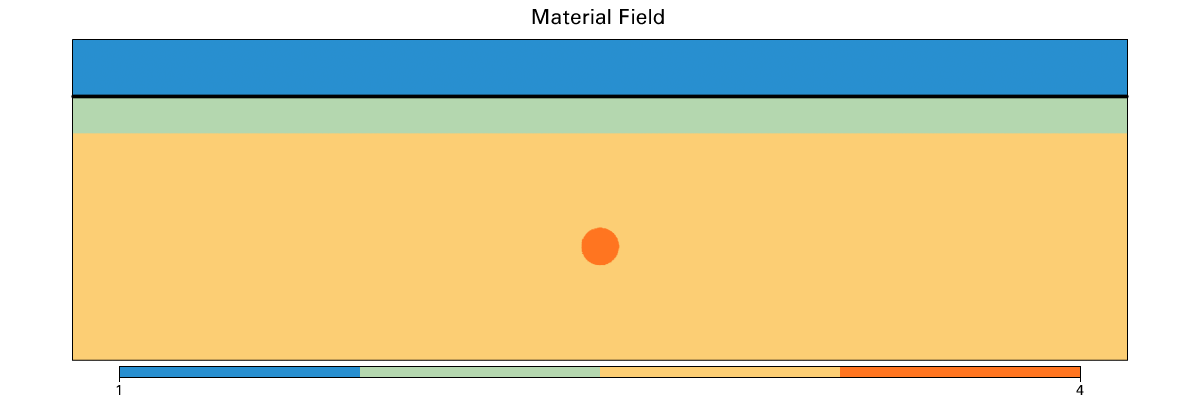

In [9]:
Fig = vis.Figure(figsize=(1200,400),title="Material Field")
Fig.Points(surf_tracers, pointSize=4.0)
Fig.Points(Model.swarm, Model.materialField,fn_size=2.0,discrete=True)
Fig.save("F_Material Field.png")
Fig.show()

In [10]:
# density
air.density =  3300. * u.kilogram / u.metre**3
li.density = 3300. * u.kilogram / u.metre**3 
ma.density = 3300. * u.kilogram / u.metre**3
mp.density = 3200. * u.kilogram / u.metre**3

In [11]:
# # compressibility
# bulk_visc = 1e15 * u.pascal * u.second
# air.compressibility = 1.0/bulk_visc
# li.compressibility = 0.0
# ma.compressibility = 0.0
# mp.compressibility = 0.0

In [12]:
# GEO.nd(air.compressibility)

In [13]:
# Model._lambdaFn.evaluate(Model.mesh)

In [14]:
# Viscosity
Model.minViscosity = 1e19 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second


air.viscosity  =  1e19 * u.pascal * u.second  
li.viscosity  =  1e23 * u.pascal * u.second                             
ma.viscosity  =  1e21 * u.pascal * u.second
mp.viscosity  =  1e20 * u.pascal * u.second

In [15]:
# Boundary conditions
Model.set_velocityBCs(left=[0., None],
                      right=[0., None],
                      bottom=[0.,0.],
                      top = [None,0.])

In [16]:
Model.solver.set_inner_method("mumps")
#Model.solver.set_penalty(0.0)
Model.solver.set_penalty(1e6)

GEO.rcParams["initial.nonlinear.max.iterations"] = 50
GEO.rcParams["nonlinear.max.iterations"] = 25
GEO.rcParams["initial.nonlinear.tolerance"]= 1e-4
GEO.rcParams["nonlinear.tolerance"]= 1e-3 

GEO.rcParams['swarm.particles.per.cell.2D'] = 36

In [17]:
Model.init_model(temperature=False, pressureField=True)

In [18]:
Model.run_for(4.0 * u.megayears, checkpoint_interval=1.0 *u.megayears,dt= dt)

Running with UWGeodynamics version 2.10.1-dev-164585a(master)
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 5000.0 year dt: 5000.0 year (2020-12-10 03:18:35)
Step:     2 Model Time: 10000.0 year dt: 5000.0 year (2020-12-10 03:19:03)
Step:     3 Model Time: 15000.0 year dt: 5000.0 year (2020-12-10 03:19:34)
Step:     4 Model Time: 20000.0 year dt: 5000.0 year (2020-12-10 03:20:02)
Step:     5 Model Time: 25000.0 year dt: 5000.0 year (2020-12-10 03:20:32)
Step:     6 Model Time: 30000.0 year dt: 5000.0 year (2020-12-10 03:21:01)
Step:     7 Model Time: 35000.0 year dt: 5000.0 year (2020-12-10 03:21:31)
Step:     8 Model Time: 40000.0 year 

Step:   104 Model Time: 520000.0 year dt: 5000.0 year (2020-12-10 04:07:32)
Step:   105 Model Time: 525000.0 year dt: 5000.0 year (2020-12-10 04:07:59)
Step:   106 Model Time: 530000.0 year dt: 5000.0 year (2020-12-10 04:08:26)
Step:   107 Model Time: 535000.0 year dt: 5000.0 year (2020-12-10 04:08:53)
Step:   108 Model Time: 540000.0 year dt: 5000.0 year (2020-12-10 04:09:20)
Step:   109 Model Time: 545000.0 year dt: 5000.0 year (2020-12-10 04:09:46)
Step:   110 Model Time: 550000.0 year dt: 5000.0 year (2020-12-10 04:10:13)
Step:   111 Model Time: 555000.0 year dt: 5000.0 year (2020-12-10 04:10:39)
Step:   112 Model Time: 560000.0 year dt: 5000.0 year (2020-12-10 04:11:05)
Step:   113 Model Time: 565000.0 year dt: 5000.0 year (2020-12-10 04:11:32)
Step:   114 Model Time: 570000.0 year dt: 5000.0 year (2020-12-10 04:11:58)
Step:   115 Model Time: 575000.0 year dt: 5000.0 year (2020-12-10 04:12:25)
Step:   116 Model Time: 580000.0 year dt: 5000.0 year (2020-12-10 04:12:51)
Step:   117 

Step:   212 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:02:48)
Step:   213 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:03:17)
Step:   214 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:03:43)
Step:   215 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:04:12)
Step:   216 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:04:38)
Step:   217 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:05:04)
Step:   218 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:05:31)
Step:   219 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:06:04)
Step:   220 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:06:33)
Step:   221 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:07:01)
Step:   222 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:07:30)
Step:   223 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:08:01)
Step:   224 Model Time: 1.1 megayear dt: 5000.0 year (2020-12-10 05:08:27)
Step:   225 Model Time: 1

Step:   322 Model Time: 1.6 megayear dt: 5000.0 year (2020-12-10 05:50:56)
Step:   323 Model Time: 1.6 megayear dt: 5000.0 year (2020-12-10 05:51:22)
Step:   324 Model Time: 1.6 megayear dt: 5000.0 year (2020-12-10 05:51:49)
Step:   325 Model Time: 1.6 megayear dt: 5000.0 year (2020-12-10 05:52:19)
Step:   326 Model Time: 1.6 megayear dt: 5000.0 year (2020-12-10 05:52:48)
Step:   327 Model Time: 1.6 megayear dt: 5000.0 year (2020-12-10 05:53:18)
Step:   328 Model Time: 1.6 megayear dt: 5000.0 year (2020-12-10 05:53:44)
Step:   329 Model Time: 1.6 megayear dt: 5000.0 year (2020-12-10 05:54:12)
Step:   330 Model Time: 1.6 megayear dt: 5000.0 year (2020-12-10 05:54:42)
Step:   331 Model Time: 1.7 megayear dt: 5000.0 year (2020-12-10 05:55:10)
Step:   332 Model Time: 1.7 megayear dt: 5000.0 year (2020-12-10 05:55:37)
Step:   333 Model Time: 1.7 megayear dt: 5000.0 year (2020-12-10 05:56:12)
Step:   334 Model Time: 1.7 megayear dt: 5000.0 year (2020-12-10 05:56:47)
Step:   335 Model Time: 1

Step:   432 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:47:06)
Step:   433 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:47:31)
Step:   434 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:47:55)
Step:   435 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:48:20)
Step:   436 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:48:45)
Step:   437 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:49:10)
Step:   438 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:49:35)
Step:   439 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:50:00)
Step:   440 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:50:24)
Step:   441 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:50:49)
Step:   442 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:51:14)
Step:   443 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:51:39)
Step:   444 Model Time: 2.2 megayear dt: 5000.0 year (2020-12-10 07:52:03)
Step:   445 Model Time: 2

Step:   542 Model Time: 2.7 megayear dt: 5000.0 year (2020-12-10 08:32:54)
Step:   543 Model Time: 2.7 megayear dt: 5000.0 year (2020-12-10 08:33:19)
Step:   544 Model Time: 2.7 megayear dt: 5000.0 year (2020-12-10 08:33:44)
Step:   545 Model Time: 2.7 megayear dt: 5000.0 year (2020-12-10 08:34:09)
Step:   546 Model Time: 2.7 megayear dt: 5000.0 year (2020-12-10 08:34:35)
Step:   547 Model Time: 2.7 megayear dt: 5000.0 year (2020-12-10 08:35:00)
Step:   548 Model Time: 2.7 megayear dt: 5000.0 year (2020-12-10 08:35:25)
Step:   549 Model Time: 2.7 megayear dt: 5000.0 year (2020-12-10 08:35:50)
Step:   550 Model Time: 2.7 megayear dt: 5000.0 year (2020-12-10 08:36:15)
Step:   551 Model Time: 2.8 megayear dt: 5000.0 year (2020-12-10 08:36:40)
Step:   552 Model Time: 2.8 megayear dt: 5000.0 year (2020-12-10 08:37:05)
Step:   553 Model Time: 2.8 megayear dt: 5000.0 year (2020-12-10 08:37:30)
Step:   554 Model Time: 2.8 megayear dt: 5000.0 year (2020-12-10 08:37:56)
Step:   555 Model Time: 2

Step:   652 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:19:47)
Step:   653 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:20:12)
Step:   654 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:20:38)
Step:   655 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:21:03)
Step:   656 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:21:28)
Step:   657 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:21:54)
Step:   658 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:22:19)
Step:   659 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:22:44)
Step:   660 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:23:10)
Step:   661 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:23:35)
Step:   662 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:24:00)
Step:   663 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:24:25)
Step:   664 Model Time: 3.3 megayear dt: 5000.0 year (2020-12-10 09:24:50)
Step:   665 Model Time: 3

Step:   762 Model Time: 3.8 megayear dt: 5000.0 year (2020-12-10 10:06:02)
Step:   763 Model Time: 3.8 megayear dt: 5000.0 year (2020-12-10 10:06:28)
Step:   764 Model Time: 3.8 megayear dt: 5000.0 year (2020-12-10 10:06:53)
Step:   765 Model Time: 3.8 megayear dt: 5000.0 year (2020-12-10 10:07:18)
Step:   766 Model Time: 3.8 megayear dt: 5000.0 year (2020-12-10 10:07:43)
Step:   767 Model Time: 3.8 megayear dt: 5000.0 year (2020-12-10 10:08:09)
Step:   768 Model Time: 3.8 megayear dt: 5000.0 year (2020-12-10 10:08:34)
Step:   769 Model Time: 3.8 megayear dt: 5000.0 year (2020-12-10 10:08:59)
Step:   770 Model Time: 3.8 megayear dt: 5000.0 year (2020-12-10 10:09:24)
Step:   771 Model Time: 3.9 megayear dt: 5000.0 year (2020-12-10 10:09:49)
Step:   772 Model Time: 3.9 megayear dt: 5000.0 year (2020-12-10 10:10:14)
Step:   773 Model Time: 3.9 megayear dt: 5000.0 year (2020-12-10 10:10:39)
Step:   774 Model Time: 3.9 megayear dt: 5000.0 year (2020-12-10 10:11:05)
Step:   775 Model Time: 3

1

In [19]:
import h5py   
import matplotlib.pyplot as plt

def load_h5_tracer(fdir,tracer_name,number,dt):
    """
    load the data of the passive tracer from h5 file
    -----------
    Input:
    fdir   : *Str*, input file dir 
    tracer_name : *Str*, name of tracer
    number : *Int*, the number of file
    dt     : *Float*, [Ma], the time interval of files
    -----------
    Output:
    coord : *Np.array*
    data  : *Np.array*  
    label : *str*
    """
    fname = fdir+tracer_name +"-"+str(number)+".h5"
    label = str(number*dt) + " Ma"
    fh5   = h5py.File(fname ,'r')  
    fdata = fh5["data"][()]
    coord = fdata[:,0]
    data  = fdata[:,1]
    return coord,data,label

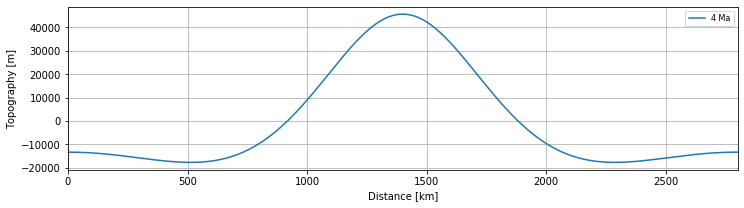

In [23]:
### not axisymmetric
tracer_name = "Surface"
number = 4
dT = 1

fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax.set(xlabel='Distance [km]', ylabel='Topography [m]') 

fdir = fdir_output+"/"
coord,elev,label = load_h5_tracer(fdir,tracer_name,number,dT)
ax.plot(coord,elev*1000,label=label)

ax.set_xlim([0,2800])
#ax.set_ylim([-200,600])
#ax.set_ylim([-200,1000])
ax.legend(loc = 'upper right',prop = {'size':8}) 
ax.grid()
fname = fdir_output+str(4)+"Ma"
plt.savefig(fname)